In [1]:
%load_ext autoreload
%autoreload 2

import json
import re
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time, sleep

from utils import *
from jigsaws_utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Device:',torch.cuda.get_device_name(device))

Device: Tesla P100-PCIE-12GB


## Classification procedure for participant B, Suturing task

In [3]:
ncomp = 10
task = 2
subject = 'B'

In [36]:
def evaluate_model(model, X, y, nsplits=5, X_transform=None):
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    confusion_matrix_cum = np.zeros((ngestures, ngestures))
    accuracy_cum = 0
    for train_index, test_index in kfolder.split(X, y, groups):
        if X_transform is not None:
            X_train = X_transform(full_martin_gram[train_index, :][:, train_index])
            X_test = X_transform(full_martin_gram[test_index, :][:, train_index])
        else:
            X_train = full_martin_gram[train_index, :][:, train_index]
            X_test = full_martin_gram[test_index, :][:, train_index]

        # Predict
        model.fit(X_train, y[train_index])
        preds = model.predict(X_test)
        cm = confusion_matrix(y[test_index], preds, normalize='true')

        # Handle of missing gestures
        if cm.shape != (ngestures,ngestures):
            missing_gestures = set(gestures) - set(preds) - set(y[test_index])
            l = cm.shape[0]
            for g in missing_gestures:
                gi = g2i[g]
                cm = np.insert(cm, gi, np.zeros(l), axis=1)
                cm = np.insert(cm, gi, np.zeros(l+1), axis=0)
                cm[gi,gi] = 1
                l = l+1

        confusion_matrix_cum += cm/nsplits
    accuracy = np.sum(np.diag(confusion_matrix_cum))/ngestures

    return accuracy, confusion_matrix_cum

### Points creation for baseline

In [4]:
video_data, y = load_video_data(tasks=task, subjects=subject)
nsample = len(y)
gestures = np.unique(y)
ngestures = len(gestures)
g2i = {g: i for i, g in enumerate(gestures)}
X = []
for video in video_data:
    video.torch = False
    all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    X.append((compression_model, A))

### Computation of all distances for baseline

In [6]:
full_martin_gram = np.zeros((len(X), len(X)))
for i, mi in enumerate(X):
    for j, mj in enumerate(X):
        if i > j:
            full_martin_gram[i,j] = full_martin_gram[j,i]
        else:
            # Check: negative values appear when computing distance. For the moment round them to zero
            # while verifying they are all small enough
            if martin_dist(mi, mj) < -1e-13:
                raise ValueError('Negative values should not appear.')

            full_martin_gram[i,j] = martin_dist(mi, mj)
full_martin_gram[full_martin_gram < 0] = 0

#### KNN

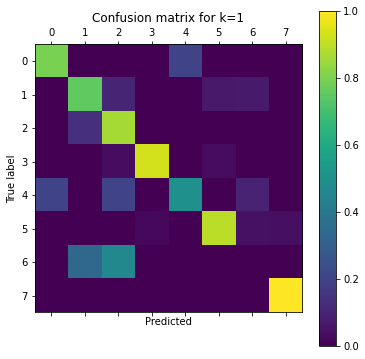

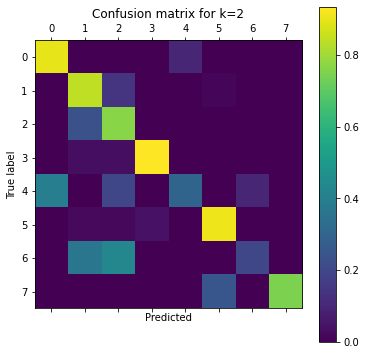

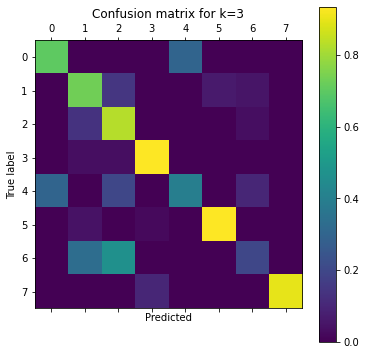

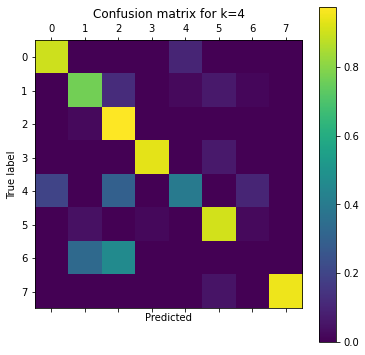

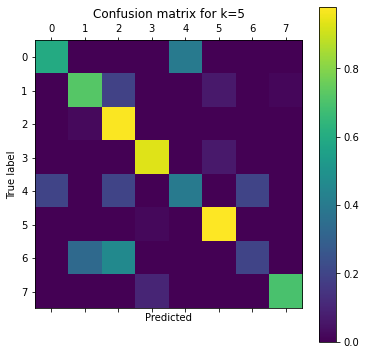

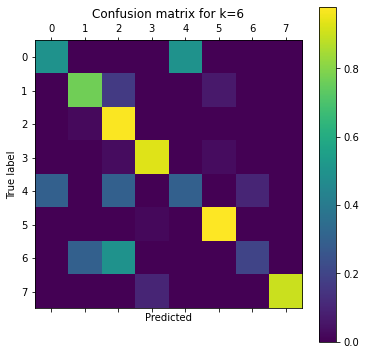

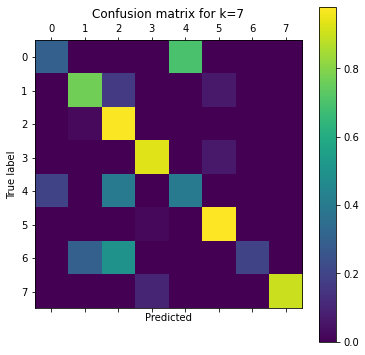

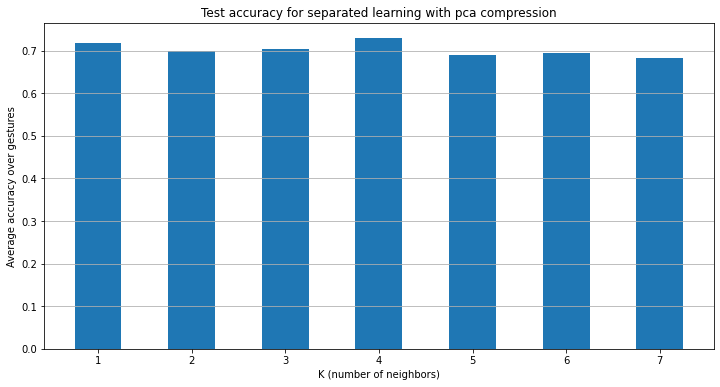

In [28]:
ks = np.arange(1, 8)
confusions_baseline_knn = np.zeros((len(ks), ngestures, ngestures))
accuracies_baseline_knn = np.zeros(len(ks))
for ki, k in enumerate(ks):
    nn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=4)
    accuracy, conf_matrix = evaluate_model(nn, X, y)
    accuracies_baseline_knn[ki] = accuracy
    confusions_baseline_knn[ki] = conf_matrix

for ki, k in enumerate(ks):
    matfig = plt.figure(figsize=(6,6))
    plt.matshow(confusions_baseline_knn[ki], fignum=matfig.number)
    plt.colorbar()
    plt.title(f'Confusion matrix for k={k}')
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.show()

plt.figure(figsize=(12, 6))
plt.title('Test accuracy for separated learning with pca compression')
plt.bar(ks, accuracies_baseline_knn, width=0.5)
plt.ylabel('Average accuracy over gestures')
plt.xlabel('K (number of neighbors)')
plt.grid(axis='y')

#### SVM

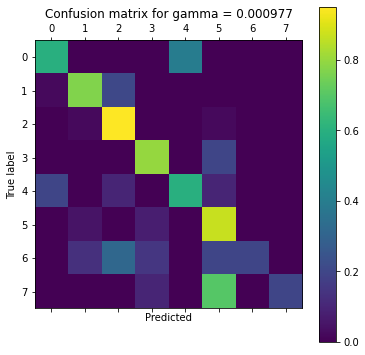

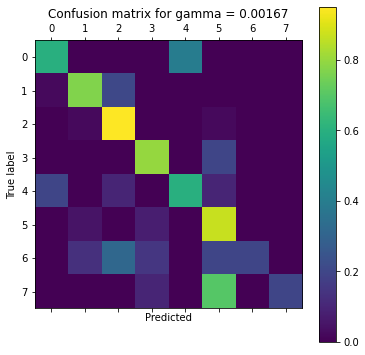

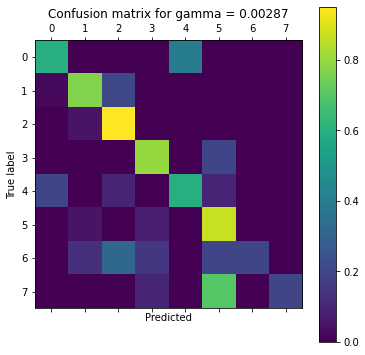

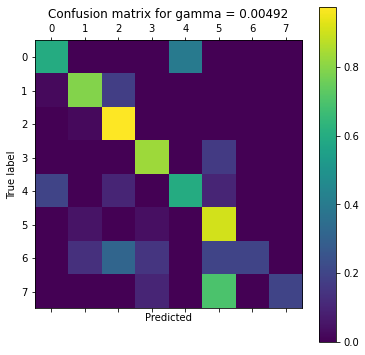

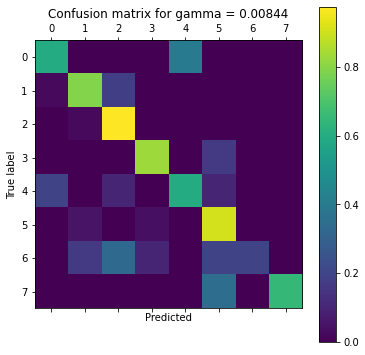

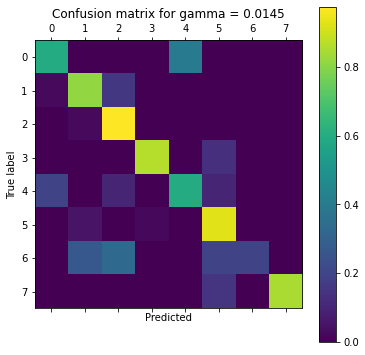

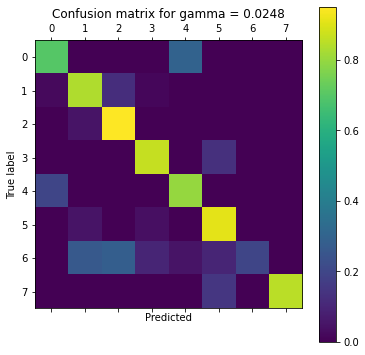

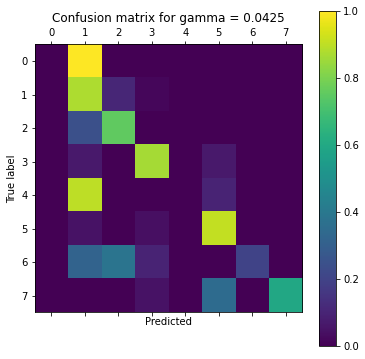

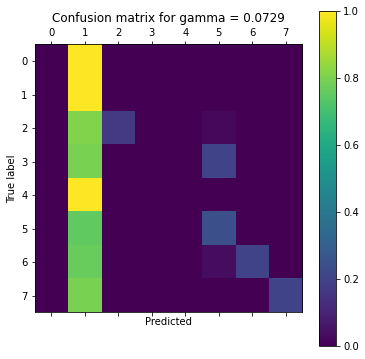

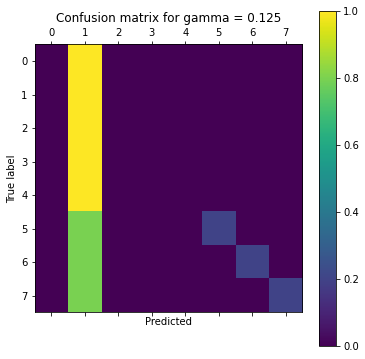

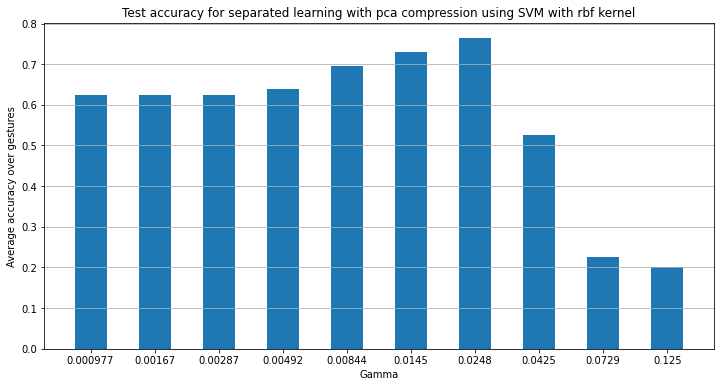

In [63]:
svm_model = SVC()
gammas = np.logspace(-10, -3, base=2, num=10)

confusions_baseline_svm = np.zeros((len(gammas), ngestures, ngestures))
accuracies_baseline_svm = np.zeros(len(gammas))
for gammai, gamma in enumerate(gammas):
    accuracy, conf_matrix = evaluate_model(svm_model, X, y, X_transform=lambda x: np.exp(-gamma*x))
    accuracies_baseline_svm[gammai] = accuracy
    confusions_baseline_svm[gammai] = conf_matrix

for gammai, gamma in enumerate(gammas):
    matfig = plt.figure(figsize=(6,6))
    plt.matshow(confusions_baseline_svm[gammai], fignum=matfig.number)
    plt.colorbar()
    plt.title(f'Confusion matrix for gamma = {gamma:.3}')
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.show()

plt.figure(figsize=(12, 6))
plt.title('Test accuracy for separated learning with pca compression using SVM with rbf kernel')
gammas_str = [f'{float(f"{gamma:.3g}"):g}' for gamma in gammas]
plt.bar(gammas_str, accuracies_baseline_svm, width=0.5)
plt.ylabel('Average accuracy over gestures')
plt.xlabel('Gamma')
plt.grid(axis='y')